# Skew-T's
## Requesting Upper Air Data from Siphon and Plotting a Skew-T with MetPy
### Based on <a href = "http://www.unidata.ucar.edu"> Unidata's </a> <i> MetPy Monday </i> \# 15 -17 YouTube links: <br>https://www.youtube.com/watch?v=OUTBiXEuDIU; <br> https://www.youtube.com/watch?v=oog6_b-844Q; <br> https://www.youtube.com/watch?v=b0RsN9mCY5k

### Import the libraries we need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import metpy.calc as mpcalc
from metpy.plots import Hodograph, SkewT
from metpy.units import units, pandas_dataframe_to_unit_arrays
from datetime import datetime, timedelta
import pandas as pd
from siphon.simplewebservice.wyoming import WyomingUpperAir
import xwrf
import xarray as xr
import pint_xarray
from pyproj import Transformer, CRS

### Next we use methods from the datetime library to determine the latest time, and then use it to select the most recent date and time that we'll use for our selected Skew-T.

In [2]:
now = datetime.now()

curr_year = now.year
curr_month = now.month
curr_day = now.day
curr_hour = now.hour

print(f"Current time is: {now}")
print(f"Current year, month, date, hour: {curr_year}, {curr_month}, {curr_day}, {curr_hour}")

if (curr_hour > 13) :
    raob_hour = 12
    hr_delta = curr_hour - 12
elif (curr_hour > 1):
    raob_hour = 0
    hr_delta = curr_hour - 0
else:
    raob_hour = 12
    hr_delta = curr_hour + 12

raob_time = now - timedelta(hours=hr_delta)

raob_year = raob_time.year
raob_month = raob_time.month
raob_day = raob_time.day
raob_hour = raob_time.hour

print(f"Time of RAOB is: {raob_year}, {raob_month}, {raob_day}, {raob_hour}")



Current time is: 2025-05-07 19:55:01.371885
Current year, month, date, hour: 2025, 5, 7, 19
Time of RAOB is: 2025, 5, 7, 12


### Construct a datetime object that we will use in our query to the data server. Note what it looks like.

In [3]:
query_date = datetime(raob_year,raob_month,raob_day,raob_hour)
query_date

datetime.datetime(2025, 5, 7, 12, 0)

### If desired, we can choose a past date and time.

In [4]:
#current = True
current = False

In [5]:
if (current == False):
    query_date = datetime(2008, 12, 11, 0)
    
raob_timeStr = query_date.strftime("%Y-%m-%d %H UTC")
raob_timeTitle = query_date.strftime("%H00 UTC %-d %b %Y")
print(raob_timeStr)
print(raob_timeTitle)

2008-12-11 00 UTC
0000 UTC 11 Dec 2008


### Select our station and query the data server.

In [6]:
station = 'ALB'

df = WyomingUpperAir.request_data (query_date,station)

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Possible data retrieval errors:</p>
    <ul>
        <li>If you get a <code>No data available for YYYY-MM-DD HHZ for station XXX </code>, you may have specified an incorrect date or location, or there just might not have been a successful RAOB at that date and time.</code></li>
        <li>If you get a <code>503 Server Error</code>, try requesting the sounding again. The Wyoming server does not handle simultaneous requests well. Usually the request will eventually work. </li>
    </ul>
    
</div>

### What does the returned data file look like? Well, it looks like a Pandas Dataframe!

In [7]:
df

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,1005.0,96,3.4,0.6,350.0,3.0,0.520945,-2.954423,ALB,72518,2008-12-11,42.7,-73.83,96.0,19.05
1,1000.0,135,2.6,-1.5,345.0,2.0,0.517638,-1.931852,ALB,72518,2008-12-11,42.7,-73.83,96.0,19.05
2,979.1,305,1.3,-1.6,265.0,2.0,1.992389,0.174311,ALB,72518,2008-12-11,42.7,-73.83,96.0,19.05
3,943.0,607,-1.1,-1.9,319.0,2.0,1.312118,-1.509419,ALB,72518,2008-12-11,42.7,-73.83,96.0,19.05
4,942.6,610,-1.1,-1.8,320.0,2.0,1.285575,-1.532089,ALB,72518,2008-12-11,42.7,-73.83,96.0,19.05
5,931.0,709,0.2,-0.2,353.0,1.0,0.121869,-0.992546,ALB,72518,2008-12-11,42.7,-73.83,96.0,19.05
6,925.0,761,0.0,-0.4,10.0,1.0,-0.173648,-0.984808,ALB,72518,2008-12-11,42.7,-73.83,96.0,19.05
7,907.5,914,-0.7,-1.2,130.0,4.0,-3.064178,2.571150,ALB,72518,2008-12-11,42.7,-73.83,96.0,19.05
8,898.0,998,-1.1,-1.7,107.0,3.0,-2.868914,0.877115,ALB,72518,2008-12-11,42.7,-73.83,96.0,19.05
9,873.6,1219,-0.5,-1.2,45.0,2.0,-1.414214,-1.414214,ALB,72518,2008-12-11,42.7,-73.83,96.0,19.05


Examine one of the columns

In [8]:
df['pressure']

0     1005.0
1     1000.0
2      979.1
3      943.0
4      942.6
5      931.0
6      925.0
7      907.5
8      898.0
9      873.6
10     850.0
11     845.0
12     823.0
13     809.8
14     770.0
15     759.0
16     726.0
17     700.0
18     589.0
19     564.0
20     517.0
21     500.0
22     400.0
23     360.0
24     337.0
25     316.0
Name: pressure, dtype: float64

### The University of Wyoming sounding reader includes a <i>units</i> attribute, which produces a Python dictionary of units specific to Wyoming sounding data.  What does it look like? 

In [9]:
df.units

{'pressure': 'hPa',
 'height': 'meter',
 'temperature': 'degC',
 'dewpoint': 'degC',
 'direction': 'degrees',
 'speed': 'knot',
 'u_wind': 'knot',
 'v_wind': 'knot',
 'station': None,
 'station_number': None,
 'time': None,
 'latitude': 'degrees',
 'longitude': 'degrees',
 'elevation': 'meter',
 'pw': 'millimeter'}

### Attach units to the various columns using MetPy's `pandas_dataframe_to_unit_arrays` function, as follows:

In [10]:
df = pandas_dataframe_to_unit_arrays(df)

Now that units are attached, how does the `pressure` column look?

In [11]:
df['pressure']

Magnitude,[1005.0 1000.0 979.1 943.0 942.6 931.0 925.0 907.5 898.0 873.6 850.0 845.0 823.0 809.8 770.0 759.0 726.0 700.0 589.0 564.0 517.0 500.0 400.0 360.0 337.0 316.0]
Units,hectopascal


### As with any Pandas Dataframe, we can select columns, so we do so now for all the relevant variables for our Skew-T. 

In [12]:
P = df['pressure']
Z = df['height']
T = df['temperature']
Td = df['dewpoint']
u = df['u_wind']
v = df['v_wind']

Now that `u` and `v` are *units aware*, we can use one of MetPy's diagnostic routines to calculate the wind speed from the vector's components.

In [13]:
wind_speed = mpcalc.wind_speed(u,v)

Thermodynamic Calculations
--------------------------

Often times we will want to calculate some thermodynamic parameters of a
sounding. The MetPy calc module has many such calculations already implemented!

* **Lifting Condensation Level (LCL)** - The level at which an air parcel's
  relative humidity becomes 100% when lifted along a dry adiabatic path.
* **Parcel Path** - Path followed by a hypothetical parcel of air, beginning
  at the surface temperature/pressure and rising dry adiabatically until
  reaching the LCL, then rising moist adiabatially.

### Calculate the LCL. Note that the units will appear at the end when we print them out!

In [14]:
lclp, lclt = mpcalc.lcl(P[0], T[0], Td[0])
print (f'LCL Pressure = ,{lclp}, LCL Temperature = ,{lclt}')

LCL Pressure = ,962.443261562791 hectopascal, LCL Temperature = ,0.002278119668915224 degree_Celsius


### Calculate the parcel profile. Here, we pass in the array of all pressure values, and specify the first (index 0, remember Python's zero-based indexing) index of the temperature and dewpoint arrays as the starting point of the parcel path.

In [15]:
parcel_prof = mpcalc.parcel_profile(P, T[0], Td[0])

### What does the parcel profile look like? Well, it's just an array of all the temperatures of the parcel at each of the pressure levels as it ascends.

In [16]:
parcel_prof

Magnitude,[276.54999999999995 276.1561936260522 274.4946885615378 272.1025564761858 272.08061789316895 271.4381991606651 271.10113626569995 270.09883120020305 269.542378690619 268.07144973150906 266.58850575392177 266.26634115518925 264.8140952960748 263.9145734792109 261.0654756249563 260.2396421652857 257.65480205802515 255.4979093704796 244.92288236221987 242.1981293093378 236.69225620449745 234.57078278037804 220.53643930241068 214.07880294852677 210.10858844854198 206.30066614892698]
Units,kelvin


### Set the limits for the x- and y-axes so they can be changed and easily re-used when desired.

In [17]:
pTop = 100
pBot = 1050
tMin = -60
tMax = 40

### Since we are plotting a skew-T, define the log-p axis.

In [18]:
logTop = np.log10(pTop)
logBot = np.log10(pBot)
interval = np.logspace(logTop,logBot) * units('hPa')

### This interval will tend to oversample points near the top of the atmosphere relative to the bottom. One effect of this will be that wind barbs will be hard to read, especially at higher levels. Use a resampling method from NumPy to deal with this.

In [19]:
idx = mpcalc.resample_nn_1d(P, interval)

### Now we can add in our plot from xWRF

In [20]:
ds=xr.open_dataset('/ktyle_rit/mp856533/atm498/icestorm/exp1/wrfout_d01_2008-12-11_00:00:00', chunks='auto').xwrf.postprocess()
ds = ds.drop_vars('O3_GFS_DU') # Avoids MetPy units-parsing error with Dobson units
ds

<xarray.Dataset> Size: 645MB
Dimensions:                    (Time: 49, y: 49, x: 49, soil_layers_stag: 4,
                                z: 56, x_stag: 50, y_stag: 50, z_stag: 57,
                                num_stoch_levels: 57, seed_dim_stag: 2)
Coordinates: (12/15)
    XLAT                       (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    XLONG                      (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    XTIME                      (Time) datetime64[ns] 392B dask.array<chunksize=(49,), meta=np.ndarray>
    XLAT_U                     (y, x_stag) float32 10kB dask.array<chunksize=(49, 50), meta=np.ndarray>
    XLONG_U                    (y, x_stag) float32 10kB dask.array<chunksize=(49, 50), meta=np.ndarray>
    XLAT_V                     (y_stag, x) float32 10kB dask.array<chunksize=(50, 49), meta=np.ndarray>
    ...                         ...
  * z_stag                     (z_stag) float32 228B 1.0 0.9938 ... 0.003327 0.0
  * Time                       (Time) datetime64[ns] 392B 2008-12-11 ... 2008...
  * x                          (x) float64 392B -8.64e+05 -8.28e+05 ... 8.64e+05
  * y                          (y) float64 392B -8.64e+05 -8.28e+05 ... 8.64e+05
  * x_stag                     (x_stag) float64 400B -8.82e+05 ... 8.82e+05
  * y_stag                     (y_stag) float64 400B -8.82e+05 ... 8.82e+05
Dimensions without coordinates: soil_layers_stag, num_stoch_levels,
                                seed_dim_stag
Data variables: (12/195)
    Times                      (Time) |S19 931B dask.array<chunksize=(49,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    ZS                         (Time, soil_layers_stag) float32 784B dask.array<chunksize=(49, 4), meta=np.ndarray>
    DZS                        (Time, soil_layers_stag) float32 784B dask.array<chunksize=(49, 4), meta=np.ndarray>
    VAR_SSO                    (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    BATHYMETRY_FLAG            (Time) int32 196B dask.array<chunksize=(49,), meta=np.ndarray>
    ...                         ...
    geopotential_height        (Time, z_stag, y, x) float32 27MB dask.array<chunksize=(5, 57, 49, 49), meta=np.ndarray>
    wind_east                  (Time, z, y, x) float32 26MB dask.array<chunksize=(5, 56, 49, 49), meta=np.ndarray>
    wind_north                 (Time, z, y, x) float32 26MB dask.array<chunksize=(5, 56, 49, 49), meta=np.ndarray>
    wind_east_10               (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    wind_north_10              (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    wrf_projection             object 8B +proj=lcc +x_0=0 +y_0=0 +a=6370000 +...
Attributes: (12/141)
    TITLE:                            OUTPUT FROM WRF V4.5.1 MODEL
    START_DATE:                      2008-12-11_00:00:00
    SIMULATION_START_DATE:           2008-12-11_00:00:00
    WEST-EAST_GRID_DIMENSION:        50
    SOUTH-NORTH_GRID_DIMENSION:      50
    BOTTOM-TOP_GRID_DIMENSION:       57
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [21]:
times=np.array(ds.Time, dtype='datetime64')
times=times.astype('datetime64[s]').tolist()
starttime=times[0]
endtime=times[48]
print(f'Our starting date and time will be {starttime}')

Our starting date and time will be 2008-12-11 00:00:00


In [22]:
def sample_wrf_ds_at_latlon(ds, lat, long):
    trf = Transformer.from_crs(CRS.from_epsg(4326), ds.wrf_projection.item(), always_xy=True)
    x, y = trf.transform(long, lat)
    return ds.interp(x=x, y=y, x_stag=x, y_stag=y)

In [23]:
ds1= sample_wrf_ds_at_latlon(ds, 42.7508, -73.5555) #KALB

In [24]:
ds1 = ds1.metpy.quantify()
ds1['dew_point_temperature'] = mpcalc.dewpoint(
    mpcalc.vapor_pressure(ds1.air_pressure, ds1.QVAPOR)
).pint.to("degC")
ds1['air_temperature'] = mpcalc.temperature_from_potential_temperature(
    ds1.air_pressure, ds1.air_potential_temperature
).pint.to("degC")
ds1['air_pressure']=ds1.air_pressure.pint.to('hPa')


### Now we are ready to create our skew-T. Plot it and save it as a PNG file.

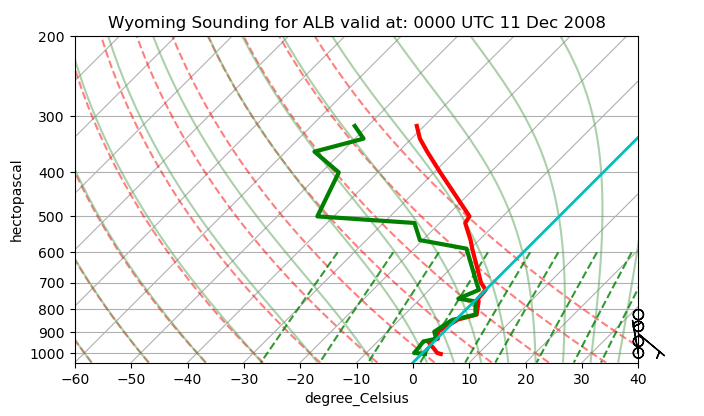

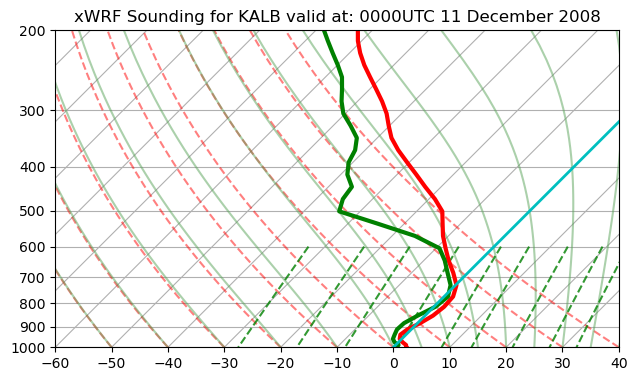

In [25]:
fig = plt.figure(figsize=(16,16));
spec = gs.GridSpec(2, 2, figure=fig);

skew = SkewT(fig,subplot=spec[0,0], rotation=45);

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(P, T, 'r', linewidth=3)
skew.plot(P, Td, 'g', linewidth=3)
skew.plot_barbs(P[idx], u[idx], v[idx])
skew.ax.set_ylim(pBot, 200)
skew.ax.set_xlim(tMin, tMax)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='-', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats(colors='#58a358', linestyle='-')
skew.plot_mixing_lines();

plt.title(f"Wyoming Sounding for {station} valid at: {raob_timeTitle}");

n=1
for h in range (0,n):
    fig = plt.figure(figsize=(16,16));
    spec = gs.GridSpec(2, 2, figure=fig);
# Dataset #1
    skew = SkewT(fig,subplot=spec[0,1], rotation=45)
    ds1=ds1.isel(Time=h)
    # Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(ds1.air_pressure.values, ds1.air_temperature.values, 'r', linewidth=3)
    skew.plot(ds1.air_pressure, ds1.dew_point_temperature, 'g', linewidth=3)
    skew.ax.barbs(ds1.air_pressure.values, ds1.wind_east.values, ds1.wind_north.values, length=6, linewidth=0.6)
    skew.ax.set_ylim(1000, 200)
    skew.ax.set_xlim(-60, 40)
    

# Plot a zero degree isotherm
    skew.ax.axvline(0, color='c', linestyle='-', linewidth=2)

# Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats(colors='#58a358', linestyle='-')
    skew.plot_mixing_lines();
    plt.title(f"xWRF Sounding for KALB valid at: 0000UTC 11 December 2008");


